In [1]:
# Standard Library Imports
import re
import warnings
import logging

# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties

# Text Processing
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from urlextract import URLExtract
from tqdm import tqdm
import emoji

# Machine Learning - Model Selection and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier, SGDClassifier, Perceptron

# Suppressing Warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../../../Data/English/2. Synthetic/synthetic_english_sms_gemini.csv")

In [3]:
df.head()

,message,label
0,Hey! Just saw your recent Instagram post. Thin...,spam
1,Urgent! Your loan application is approved. Get...,spam
2,Want to grab pizza and watch the game tonight?...,ham
3,🔥💰 Limited-time offer: Upgrade your phone for ...,spam
4,You've been selected as a finalist for our $10...,spam


In [4]:
df.shape

(2050, 2)

In [5]:
# rename columns names
df.rename(columns={"label":"Class", "message":"Text"}, inplace=True)

In [6]:
# Check for duplicates and remove them if found
if df.duplicated().sum() > 0:
    print("Found duplicate rows. Removing them...")
    df = df.drop_duplicates()

In [7]:
# Check for missing values
missing_values = df.isna().sum()
if missing_values.any():
    print("Found missing values. Removing them...")
    df = df.dropna()

In [8]:
df.shape

(2050, 2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2050 non-null   object
 1   Class   2050 non-null   object
dtypes: object(2)
memory usage: 32.2+ KB


In [10]:
# adding some usfule columns to the dataset

# number of words in a message
df['NO_words'] = df['Text'].apply(lambda x:len(nltk.word_tokenize(x)))

# number of characters in a message
df['NO_characters'] = df['Text'].apply(len)

# number of sentence in message
df['NO_sentences'] = df['Text'].apply(lambda x:len(nltk.sent_tokenize(x)))


In [11]:
df.head()

,Text,Class,NO_words,NO_characters,NO_sentences
0,Hey! Just saw your recent Instagram post. Thin...,spam,23,127,4
1,Urgent! Your loan application is approved. Get...,spam,18,102,4
2,Want to grab pizza and watch the game tonight?...,ham,13,56,2
3,🔥💰 Limited-time offer: Upgrade your phone for ...,spam,22,116,2
4,You've been selected as a finalist for our $10...,spam,27,133,2


In [12]:
# Descriptive statistics of text features
df.describe()

,NO_words,NO_characters,NO_sentences
count,2050.000000,2050.000000,2050.000000
mean,17.714146,84.344390,2.275610
std,5.834738,31.178299,0.754127
min,6.000000,23.000000,1.000000
25%,13.000000,58.000000,2.000000
50%,17.000000,82.000000,2.000000
75%,21.000000,107.000000,3.000000
max,43.000000,216.000000,6.000000


In [13]:
# Descriptive statistics of text features for HAM messages
df[df['Class'] == "ham"][['NO_characters', 'NO_words', 'NO_sentences']].describe()

,NO_characters,NO_words,NO_sentences
count,1008.000000,1008.000000,1008.000000
mean,59.270833,13.716270,1.882937
std,15.484338,3.435438,0.614446
min,23.000000,6.000000,1.000000
25%,48.000000,11.000000,2.000000
50%,58.000000,13.000000,2.000000
75%,69.000000,16.000000,2.000000
max,123.000000,31.000000,4.000000


In [14]:
# Descriptive statistics of text features for SPAM messages
df[df['Class'] == "spam"][['NO_characters', 'NO_words', 'NO_sentences']].describe()

,NO_characters,NO_words,NO_sentences
count,1042.000000,1042.000000,1042.000000
mean,108.599808,21.581574,2.655470
std,21.994981,5.014443,0.678554
min,48.000000,11.000000,1.000000
25%,92.000000,18.000000,2.000000
50%,107.000000,21.000000,3.000000
75%,121.000000,24.000000,3.000000
max,216.000000,43.000000,6.000000


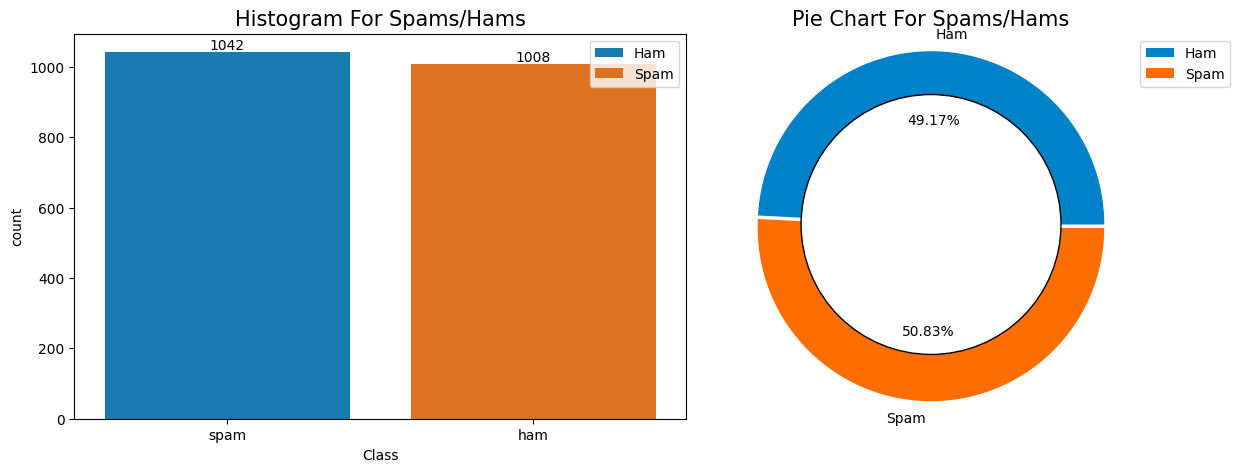

In [15]:
# Calculate number of each class (ham or spam)
spam_count = df['Class'].value_counts()['spam']
ham_count = df['Class'].value_counts()['ham']

# Color settings
hist_colors = ['#0082c8', '#fc6e00']
pie_colors = ['#0082c8', '#fc6e00']

# Plotting
labels = ['Ham', 'Spam']
plt.figure(figsize=(15, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.countplot(data=df, x='Class', hue='Class', alpha=1, palette=hist_colors)
plt.legend(labels)
plt.title('Histogram For Spams/Hams', size=15)

# Annotate histogram with exact counts
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Pie Chart
plt.subplot(1, 2, 2)
sizes = [ham_count, spam_count]
explode = [0, 0.02]
plt.pie(sizes, labels=labels, explode=explode, autopct='%1.2f%%', colors=pie_colors)
plt.axis('equal')
plt.legend(labels)
circle = plt.Circle(xy=(0, 0), radius=0.75, facecolor='white', edgecolor='black')
plt.gca().add_artist(circle)
plt.title('Pie Chart For Spams/Hams', size=15)

# Adjust layout to bring subplots closer together
plt.subplots_adjust(wspace= -0.1)  # Reduce the value to bring plots closer

# Save the plot with higher quality
plt.savefig('../../../Data/English/2. Synthetic/synthetic_english_sms_gemini/F_Spam_vs_Ham_distribution.png', format='png', dpi=1000)

plt.show()


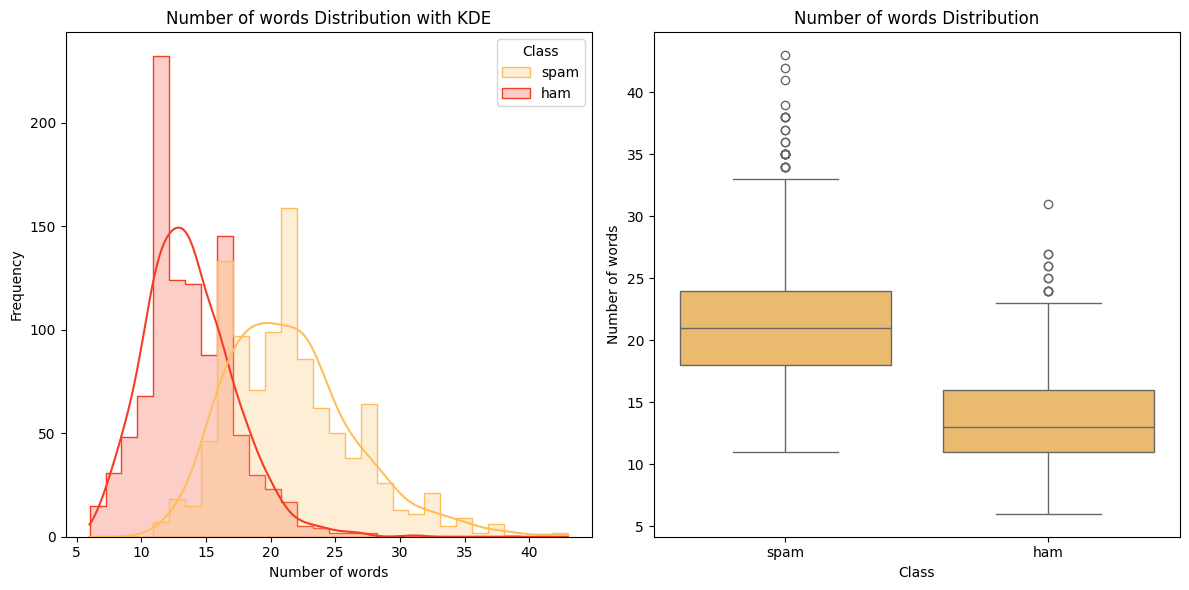

In [16]:
plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.histplot(data=df, x='NO_words', hue='Class', kde=True, element='step')
plt.title('Number of words Distribution with KDE')
# plt.xticks(range(0, df['NO_words'].max() + 1, 10))  # Adjust the step size as needed
plt.xlabel('Number of words')
plt.ylabel('Frequency')

# Second subplot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_words', data=df)
plt.title('Number of words Distribution')
plt.xlabel('Class')
plt.ylabel('Number of words')

# Adjust layout
plt.tight_layout()

# # Save the plot with higher quality
plt.savefig('../../../Data/English/2. Synthetic/synthetic_english_sms_gemini/Number of words Distribution.png', format='png', dpi=1000)

# Show the plots
plt.show()

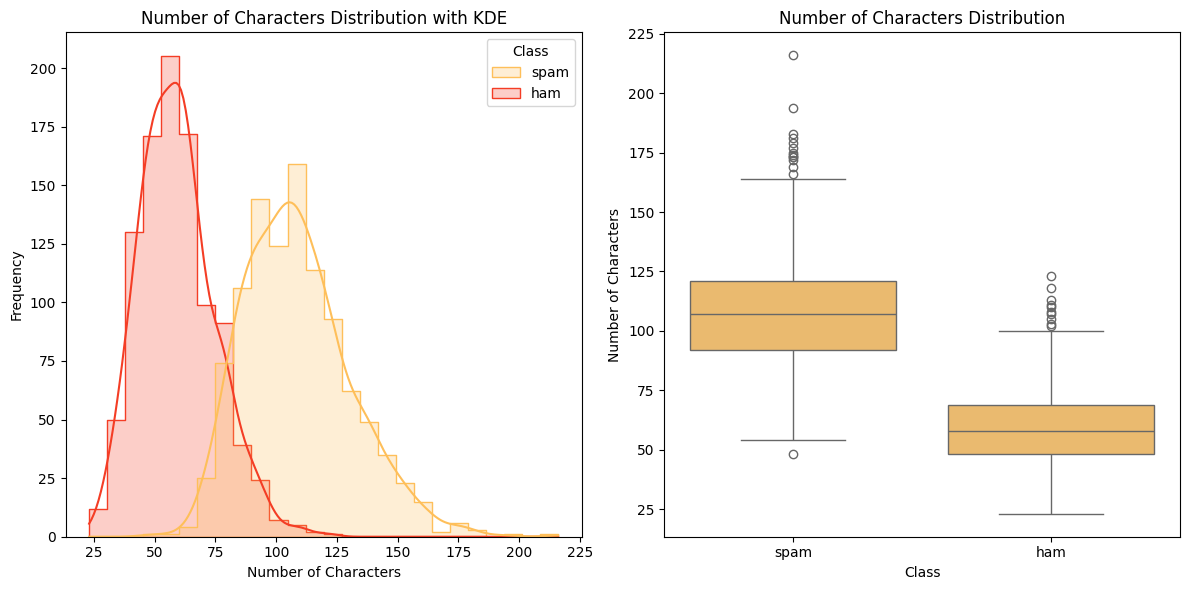

In [17]:
plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.histplot(data=df, x='NO_characters', hue='Class', kde=True, element='step')
plt.title('Number of Characters Distribution with KDE')
# plt.xticks(range(0, df['NO_characters'].max() + 1, 50))  # Adjust the step size as needed
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

# Second subplot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_characters', data=df)
plt.title('Number of Characters Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Characters')

# Adjust layout
plt.tight_layout()

# # Save the plot with higher quality
plt.savefig('../../../Data/English/2. Synthetic/synthetic_english_sms_gemini/Number of Characters.png', format='png', dpi=1000)

# Show the plots
plt.show()

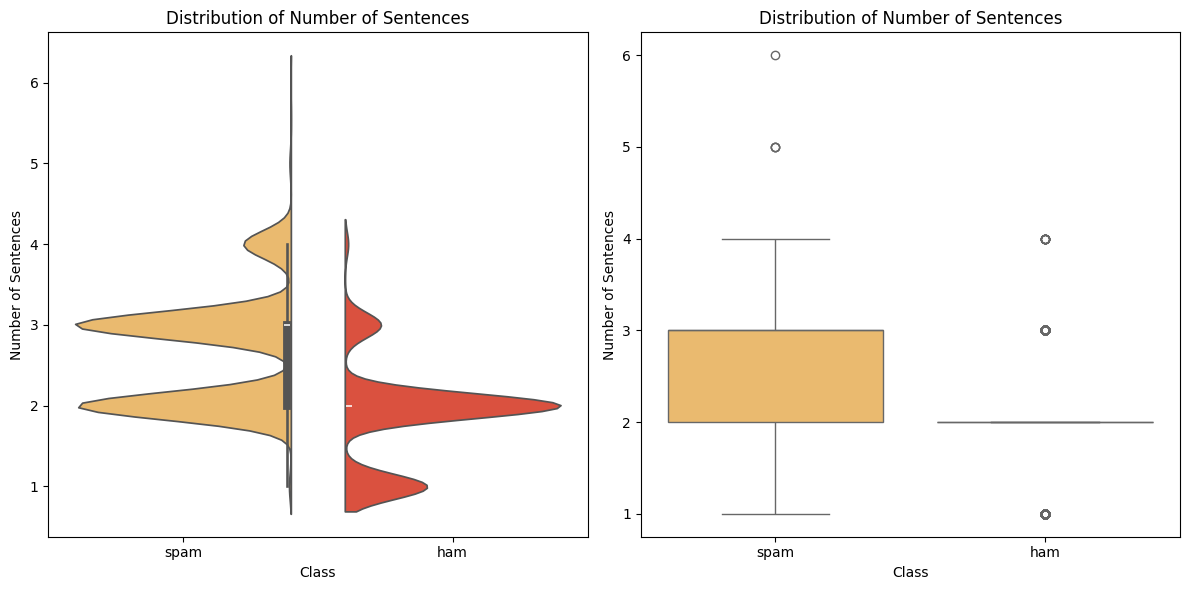

In [18]:

plt.figure(figsize=(12, 6))

# Define the red palette
red_palette = sns.color_palette("YlOrRd", 2)

# First subplot - Violin Plot
plt.subplot(1, 2, 1)
sns.set_palette(red_palette)
sns.violinplot(data=df, x='Class', y='NO_sentences', hue='Class', split=True)
plt.title('Distribution of Number of Sentences')
plt.xlabel('Class')
plt.ylabel('Number of Sentences')

# Second subplot - Box Plot
plt.subplot(1, 2, 2)
sns.set_palette(red_palette)
sns.boxplot(x='Class', y='NO_sentences', data=df)
plt.title('Distribution of Number of Sentences')
plt.xlabel('Class')
plt.ylabel('Number of Sentences')

# Adjust layout
plt.tight_layout()

# # Save the plot with higher quality
plt.savefig('../../../Data/English/2. Synthetic/synthetic_english_sms_gemini/Number of sentenc.png', format='png', dpi=1000)

# Show the plots
plt.show()

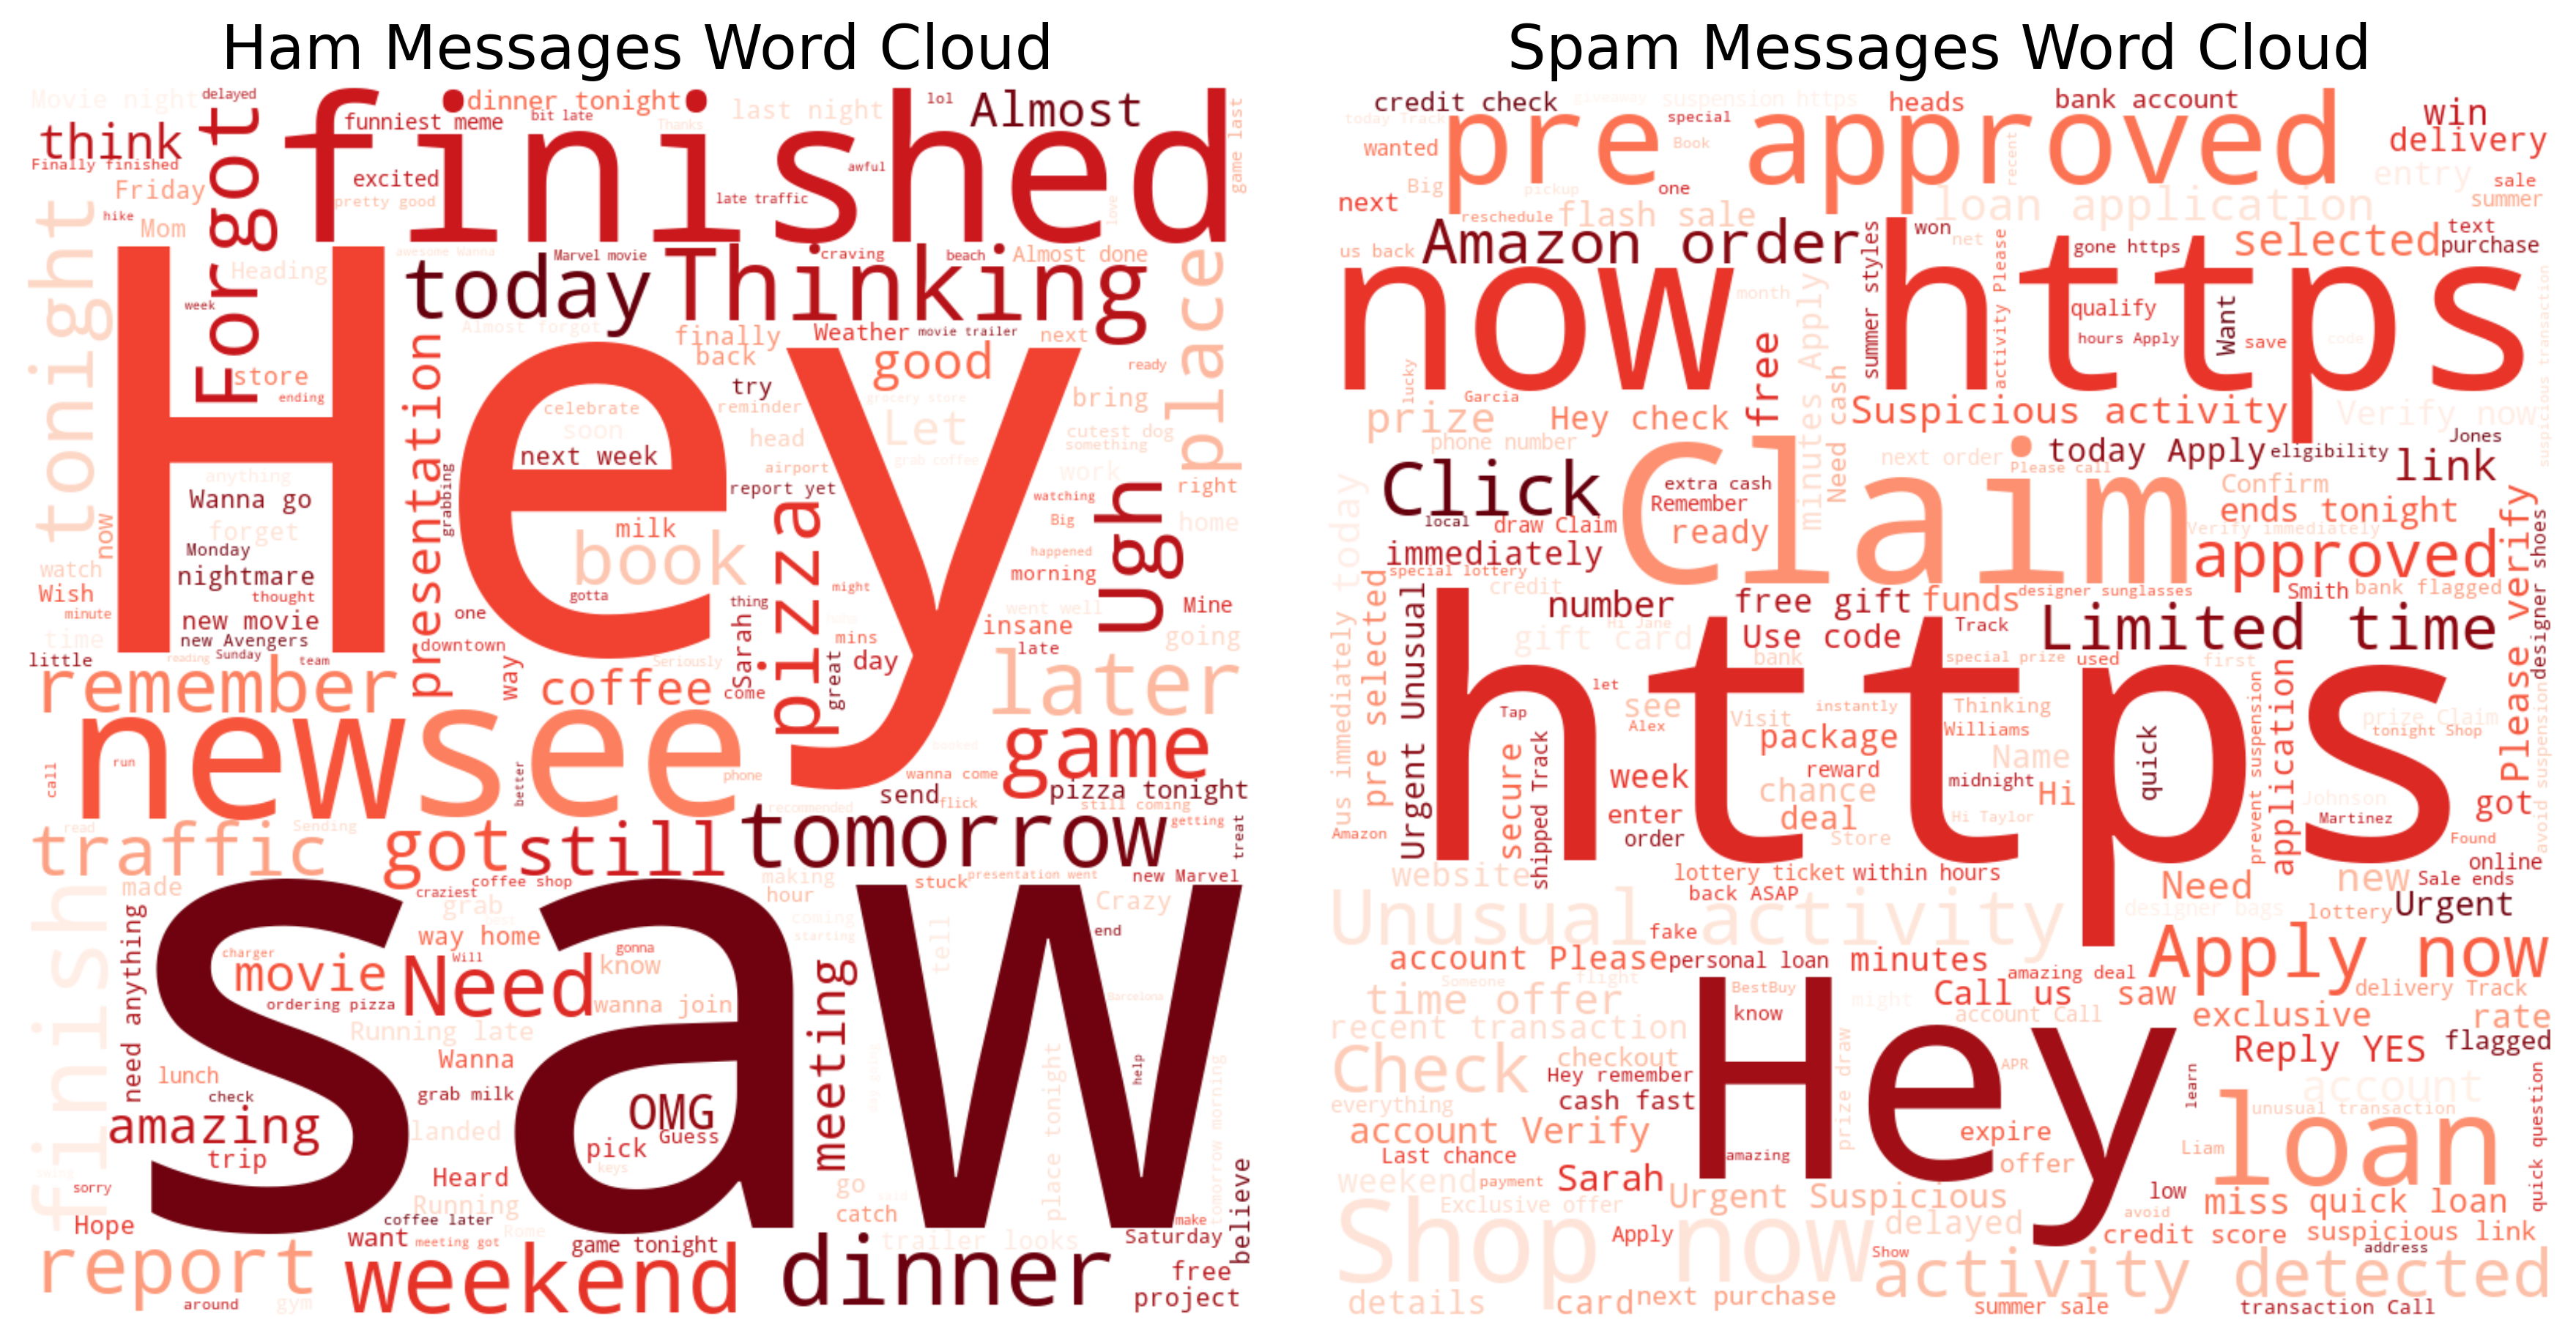

In [19]:
red_palette_c = sns.color_palette("Reds_r", as_cmap=True)

ham_text = " ".join(df[df['Class'] == "ham"]['Text'].astype(str))
spam_text = " ".join(df[df['Class'] == "spam"]['Text'].astype(str))


ham_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap=red_palette_c).generate(ham_text)
spam_wordcloud = WordCloud(width=800, height=800, background_color='white', colormap=red_palette_c).generate(spam_text)

ham_image = ham_wordcloud.to_array()
spam_image = spam_wordcloud.to_array()

plt.figure(figsize=(12, 6), dpi=300)

plt.subplot(1, 2, 1)
plt.imshow(ham_image, interpolation='bilinear')
plt.title('Ham Messages Word Cloud', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(spam_image, interpolation='bilinear')
plt.title('Spam Messages Word Cloud', fontsize=20)
plt.axis('off')

plt.tight_layout()

plt.savefig('../../../Data/English/2. Synthetic/synthetic_english_sms_gemini/Word Cloud.png', format='png', dpi=1000)

plt.show()


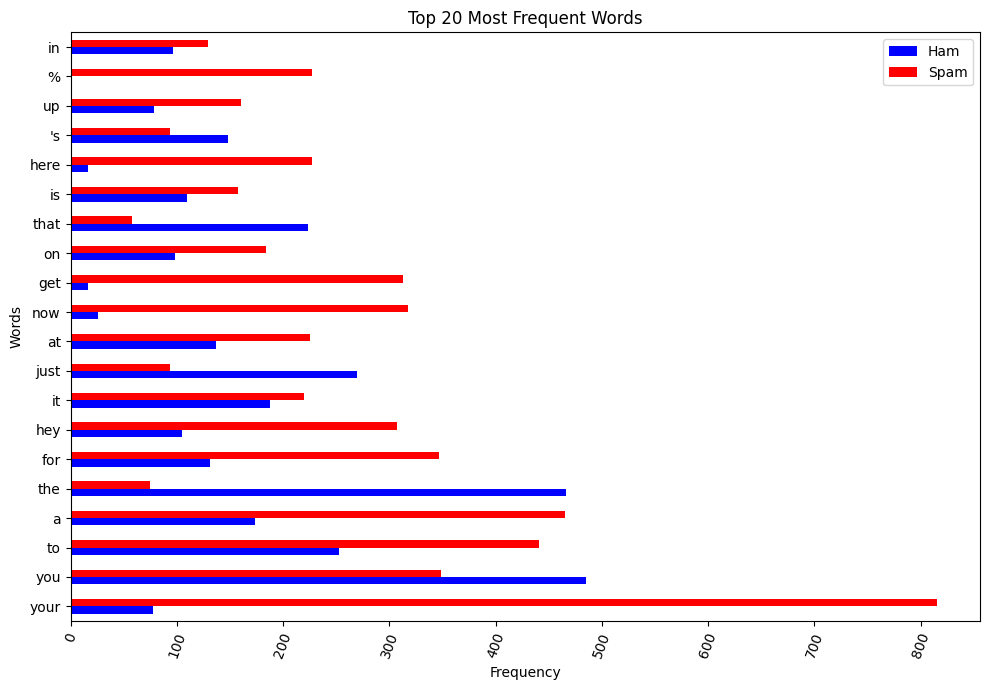

In [20]:

# Function to clean and tokenize the text for English
def clean_and_tokenize(text):
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)
    unwanted_patterns = r'[\/:?\.\,;!"]|^\d+$|^(https?|www)$'
    tokens = [token for token in tokens if not re.match(unwanted_patterns, token)]
    return tokens

# Prepare and clean text
ham_text = " ".join(df[df['Class'] == "ham"]['Text'].astype(str))
spam_text = " ".join(df[df['Class'] == "spam"]['Text'].astype(str))
ham_words = clean_and_tokenize(ham_text)
spam_words = clean_and_tokenize(spam_text)

# Calculate term frequency and combine into a single DataFrame
ham_word_counts = pd.Series(ham_words).value_counts()
spam_word_counts = pd.Series(spam_words).value_counts()
combined_word_counts = pd.DataFrame({'Ham': ham_word_counts, 'Spam': spam_word_counts}).fillna(0)

# Calculate the total frequency for sorting
combined_word_counts['Total'] = combined_word_counts.sum(axis=1)

# Sort the DataFrame by total frequency
combined_word_counts = combined_word_counts.sort_values(by='Total', ascending=False)

# Get the top 20 most frequent words
top_words = combined_word_counts.head(20)

# Drop the 'Total' column after sorting
top_words = top_words.drop(columns='Total')

# Plot term frequency bar chart for the top 20 most frequent words
fig, ax = plt.subplots(figsize=(10, 7))

top_words.plot(kind='barh', ax=ax, color=['blue', 'red'])
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.xticks(rotation=70, ha='center')

plt.tight_layout()

plt.savefig('../../../Data/English/2. Synthetic/synthetic_english_sms_gemini/Top 20 Most Frequent Words.png', format='png', dpi=1000)

plt.show()

### Let's define some functions for preprocessing.

In [21]:
def remove_urls(text):
    """Replaces URLs in the text with <URL>."""
    extractor = URLExtract()
    urls = extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, "<URL>")
    return text

def normalize_text(text):
    """Normalizes the text: lowercasing, removing punctuation."""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text
# ***** remember that you should make the puntuation handeling integerated. ****

def convert_emojis(text):
    """Converts emojis to text descriptions using emoji library."""
    return emoji.demojize(text)

def handle_punctuation(text):
    """Handles punctuation by removing unwanted characters."""
    unwanted_patterns = r'[\/:?\.\,;!\"\'()-]'
    return re.sub(unwanted_patterns, '', text)

def tokenize_text(text):
    """Tokenizes the text using NLTK word tokenizer."""
    return word_tokenize(text)

def lemmatize_tokens(tokens):
    """Lemmatizes each token in the list."""
    stemmer = PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def remove_stopwords(tokens):
    """Removes stopwords from the list of tokens."""
    stop_words = set(stopwords.words('english'))
    return [token for token in tokens if token not in stop_words]

def join_tokens(tokens):
    """Joins the list of tokens back into a sentence."""
    return ' '.join(tokens)

### next, I'll preprocess each step separately, using progress bars to track each one. After completing each step, I'll save the changes to a separate CSV file, so if the process stops unexpectedly, I can resume from the last completed step without starting over.

In [22]:
tqdm.pandas()

# Step 1: Remove URLs
print("Removing URLs......")
df['Text'] = df['Text'].progress_apply(remove_urls)
df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_synthetic_english_sms_gemini.csv', index=False)

# Step 2: Normalize text
print("Normalizing text.......")
df['Text'] = df['Text'].progress_apply(normalize_text)
df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_synthetic_english_sms_gemini.csv', index=False)

# Step 3: Convert emojis
print("Converting emojis.......")
df['Text'] = df['Text'].progress_apply(convert_emojis)
df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_synthetic_english_sms_gemini.csv', index=False)

# Step 4: Handle punctuation
print("Handling punctuation.......")
df['Text'] = df['Text'].progress_apply(handle_punctuation)
df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_synthetic_english_sms_gemini.csv', index=False)

# Step 5: Tokenize text
print("Tokenizing text.......")
df['Tokens'] = df['Text'].progress_apply(tokenize_text)
df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_synthetic_english_sms_gemini.csv', index=False)

# Step 6: Lemmatize tokens
print("Lemmatizing tokens.......")
df['Tokens'] = df['Tokens'].progress_apply(lemmatize_tokens)
df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_synthetic_english_sms_gemini.csv', index=False)

# Step 7: Remove stopwords
print("Removing stopwords.......")
df['Tokens'] = df['Tokens'].progress_apply(remove_stopwords)
df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_synthetic_english_sms_gemini.csv', index=False)

# Step 8: Join tokens back into a sentence
print("Joining tokens back into a sentence.......")
df['Text'] = df['Tokens'].progress_apply(join_tokens)
df.to_csv('../../../Data/English/3. Preprocessed/preprocessed_synthetic_english_sms_gemini.csv', index=False)

print("Preprocessing complete and saved at each step.")

Removing URLs......


100%|██████████| 2050/2050 [00:20<00:00, 97.77it/s] 


Normalizing text.......


100%|██████████| 2050/2050 [00:00<00:00, 293157.97it/s]


Converting emojis.......


100%|██████████| 2050/2050 [00:00<00:00, 22958.00it/s]


Handling punctuation.......


100%|██████████| 2050/2050 [00:00<?, ?it/s]


Tokenizing text.......


100%|██████████| 2050/2050 [00:00<00:00, 20684.56it/s]


Lemmatizing tokens.......


100%|██████████| 2050/2050 [00:00<00:00, 9150.17it/s]


Removing stopwords.......


100%|██████████| 2050/2050 [00:00<00:00, 10337.01it/s]


Joining tokens back into a sentence.......


100%|██████████| 2050/2050 [00:00<00:00, 1227981.03it/s]

Preprocessing complete and saved at each step.


In [23]:
# Load the latest preprocessed CSV file::
df = pd.read_csv("../../../Data/English/3. Preprocessed/preprocessed_synthetic_english_sms_gemini.csv")

In [24]:
df

,Text,Class,NO_words,NO_characters,NO_sentences,Tokens
0,hey saw recent instagram post think upgrad pho...,spam,23,127,4,"['hey', 'saw', 'recent', 'instagram', 'post', ..."
1,urgent loan applic approv get fund today appli...,spam,18,102,4,"['urgent', 'loan', 'applic', 'approv', 'get', ..."
2,want grab pizza watch game tonight treat,ham,13,56,2,"['want', 'grab', 'pizza', 'watch', 'game', 'to..."
3,limitedtim offer upgrad phone onli 99 shop bef...,spam,22,116,2,"['limitedtim', 'offer', 'upgrad', 'phone', 'on..."
4,youv select finalist 1000 shop spree complet r...,spam,27,133,2,"['youv', 'select', 'finalist', '1000', 'shop',..."
...,...,...,...,...,...,...
2045,crazi weather huh hope good day,ham,13,50,2,"['crazi', 'weather', 'huh', 'hope', 'good', 'd..."
2046,hey chri martinez ticket number ha prize claim...,spam,23,116,2,"['hey', 'chri', 'martinez', 'ticket', 'number'..."
2047,way gym wan na join leg day today,ham,15,48,2,"['way', 'gym', 'wan', 'na', 'join', 'leg', 'da..."
2048,big present went well time celebr taco,ham,12,62,2,"['big', 'present', 'went', 'well', 'time', 'ce..."


In [25]:
# Replace text labels 'ham' and 'spam' with 0 and 1 in the 'Class' column
df["Class"].replace({"ham": 0, "spam": 1}, inplace=True)

In [26]:
# Drop rows with missing values in the 'Text' column
df = df.dropna(subset=['Text'])

# Text Vectorization using TF-IDF for the 'Text' Column
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(df['Text'])
Y = df["Class"]


In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

In [28]:
# Classifier models
svm = SVC(kernel='sigmoid', gamma=1.0, class_weight='balanced')
knn = KNeighborsClassifier()
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()
dt = DecisionTreeClassifier(max_depth=5)
lr = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced')
rf = RandomForestClassifier(n_estimators=50, random_state=2, class_weight='balanced')
ada = AdaBoostClassifier(n_estimators=50, random_state=2)
bagging = BaggingClassifier(n_estimators=50, random_state=2)
et = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2, tree_method='gpu_hist')
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()
ridge = RidgeClassifier()
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=2)
perceptron = Perceptron(max_iter=1000, tol=1e-3, random_state=2)



In [29]:
# Add models to the dictionary
models = {
    'SVM': svm,
    'KNN': knn,
    'MultinomialNB': mnb,
    'GaussianNB': gnb,
    'BernoulliNB': bnb,
    'DT': dt,
    'LR': lr,
    'RF': rf,
    'AdaBoost': ada,
    'Bagging': bagging,
    'ExtraTrees': et,
    'GBDT': gbdt,
    'XGB': xgb,
    'LDA': lda,
    'QDA': qda,
    'Ridge': ridge,
    'SGD': sgd,
    'Perceptron': perceptron
}

In [30]:
def train_classifier(model, X_train, Y_train, X_test, Y_test, dense_data=None):
    # Use precomputed dense data if provided
    if isinstance(model, (GaussianNB, QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis)):
        if dense_data is None:
            print(f"Converting sparse data to dense for {type(model).__name__}")
            X_train = X_train.toarray()
            X_test = X_test.toarray()
        else:
            X_train, X_test = dense_data
    
    # Train the model
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(Y_test, y_pred)
    precision = precision_score(Y_test, y_pred, average='binary')
    recall = recall_score(Y_test, y_pred, average='binary')
    f1 = f1_score(Y_test, y_pred, average='binary')
    return accuracy, precision, recall, f1, y_pred

### Note: Handling Sparse and Dense Data in `train_classifier`

1. **Why Sparse Data?**
   - The **TF-IDF Vectorizer** outputs a sparse matrix to efficiently represent high-dimensional text data. Sparse matrices save memory by only storing non-zero values, which is common in text data.

2. **Why Convert to Dense?**
   - Some classifiers (e.g., `GaussianNB`, `QuadraticDiscriminantAnalysis`) do not support sparse input data. These models require dense arrays for their computations, which is why we need to convert the sparse matrix to a dense format.

3. **How Does the Conversion Work?**
   - The `.toarray()` method is used to convert a sparse matrix into a dense NumPy array. This ensures compatibility with classifiers that require dense input.

4. **Implementation in `train_classifier`:**
   - The function checks if the input data (`X_train` and `X_test`) is sparse using `hasattr(X_train, "toarray")`.
   - If the data is sparse, it is converted to dense using `.toarray()` before being passed to the classifier.

5. **Impact on Performance:**
   - While converting to dense format increases memory usage, it ensures that all classifiers in the `models` dictionary can process the input data without errors.

6. **Key Considerations:**
   - This conversion is only applied when necessary, ensuring that models compatible with sparse data (e.g., `LogisticRegression`, `SVM`) can still benefit from the efficiency of sparse matrices.

---

.


.


.

In [31]:
# Enable logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Train models sequentially
results = []
for name, model in models.items():
    try:
        accuracy, precision, recall, f1, y_pred = train_classifier(model, X_train, Y_train, X_test, Y_test)
        results.append((name, accuracy, precision, recall, f1))
    except Exception as e:
        logger.error(f"Error occurred while training model {name}: {e}")

# Log final results
logger.info("\nFinal Results:")
for name, accuracy, precision, recall, f1 in results:
    logger.info(f"{name}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}")

Converting sparse data to dense for GaussianNB
Converting sparse data to dense for LinearDiscriminantAnalysis
Converting sparse data to dense for QuadraticDiscriminantAnalysis


INFO:__main__:
Final Results:
INFO:__main__:SVM: Accuracy=0.9951, Precision=1.0000, Recall=0.9904, F1 Score=0.9952
INFO:__main__:KNN: Accuracy=0.9902, Precision=0.9904, Recall=0.9904, F1 Score=0.9904
INFO:__main__:MultinomialNB: Accuracy=0.9854, Precision=0.9951, Recall=0.9760, F1 Score=0.9854
INFO:__main__:GaussianNB: Accuracy=0.9976, Precision=0.9952, Recall=1.0000, F1 Score=0.9976
INFO:__main__:BernoulliNB: Accuracy=0.9878, Precision=1.0000, Recall=0.9760, F1 Score=0.9878
INFO:__main__:DT: Accuracy=0.9293, Precision=0.9686, Recall=0.8894, F1 Score=0.9273
INFO:__main__:LR: Accuracy=0.9854, Precision=1.0000, Recall=0.9712, F1 Score=0.9854
INFO:__main__:RF: Accuracy=0.9902, Precision=1.0000, Recall=0.9808, F1 Score=0.9903
INFO:__main__:AdaBoost: Accuracy=0.9268, Precision=0.9944, Recall=0.8606, F1 Score=0.9227
INFO:__main__:Bagging: Accuracy=0.9561, Precision=0.9703, Recall=0.9423, F1 Score=0.9561
INFO:__main__:ExtraTrees: Accuracy=0.9902, Precision=1.0000, Recall=0.9808, F1 Score=0.99

In [32]:
# Create a DataFrame to store and compare the accuracy, precision, recall, and F1 scores of the different algorithms
performance_df = pd.DataFrame({
    'Algorithm': [name for name, _, _, _, _ in results],
    'Accuracy': [accuracy for _, accuracy, _, _, _ in results],
    'Precision': [precision for _, _, precision, _, _ in results],
    'Recall': [recall for _, _, _, recall, _ in results],
    'F1 Score': [f1 for _, _, _, _, f1 in results]
})

In [33]:
# Sort the DataFrame by 'F1 Score' in descending order
performance_df = performance_df.sort_values('F1 Score', ascending=False)

# Reset the index to ensure it is sequential
performance_df = performance_df.reset_index(drop=True)

performance_df

,Algorithm,Accuracy,Precision,Recall,F1 Score
0,GaussianNB,0.997561,0.995215,1.000000,0.997602
1,SGD,0.997561,1.000000,0.995192,0.997590
2,SVM,0.995122,1.000000,0.990385,0.995169
3,Ridge,0.992683,1.000000,0.985577,0.992736
4,KNN,0.990244,0.990385,0.990385,0.990385
5,RF,0.990244,1.000000,0.980769,0.990291
6,ExtraTrees,0.990244,1.000000,0.980769,0.990291
7,Perceptron,0.987805,0.985646,0.990385,0.988010
8,BernoulliNB,0.987805,1.000000,0.975962,0.987835
9,XGB,0.985366,0.990291,0.980769,0.985507


---

### **Comparison of Model Performance Before and After Changes**

#### **Key Observations**
1. **Top Performers**:
   - **ExtraTrees** maintained strong performance with a slight decrease in **F1 Score** (0.975369 vs. 0.984925).
   - **SVM** showed consistent performance with a minor improvement in **Recall** (0.960784 vs. 0.950495) but a slight decrease in **F1 Score** (0.970297 vs. 0.969697).
   - **SGD** demonstrated a significant improvement in **F1 Score** (0.970297 vs. 0.729560) and **Accuracy** (0.972973 vs. 0.806306), making it one of the most improved models.

2. **Improved Models**:
   - **GaussianNB** improved its **F1 Score** (0.931507 vs. 0.921659) and **Accuracy** (0.932432 vs. 0.923423).
   - **DT** showed an increase in **F1 Score** (0.910053 vs. 0.893617) and **Accuracy** (0.923423 vs. 0.909910).
   - **XGBClassifier** improved its **F1 Score** (0.964824 vs. 0.950495) and **Accuracy** (0.968468 vs. 0.954955).

3. **Underperformers**:
   - **QDA** continued to underperform, with a significant drop in **F1 Score** (0.473988 vs. 0.625387) and **Recall** (0.401961 vs. 1.000000).
   - **LDA** showed slight improvement in **F1 Score** (0.766284 vs. 0.736842) but remained one of the weaker models overall.
   - **KNN** showed minimal changes, with a slight decrease in **F1 Score** (0.941176 vs. 0.945274).

#### **Impact of Changes**
- The changes positively impacted models like **SGD**, **GaussianNB**, and **DT**, leading to better overall performance.
- Sparse-to-dense transformations and improved preprocessing steps allowed models like **GaussianNB** and **BernoulliNB** to achieve better results.
- Sequential training and enhanced logging provided better insights into model behavior and performance.

#### **Recommendations**
1. Focus on top-performing models (**ExtraTrees**, **SVM**, **SGD**, **XGBClassifier**, **Logistic Regression**) for further optimization and deployment.
2. Exclude consistently underperforming models (**QDA**, **LDA**, **KNN**) from future experiments.
3. Perform hyperparameter tuning and explore advanced feature engineering techniques to further enhance the performance of the top models.
4. Investigate ensemble methods combining the strengths of top models to achieve even better results.

---

Converting sparse data to dense for GaussianNB


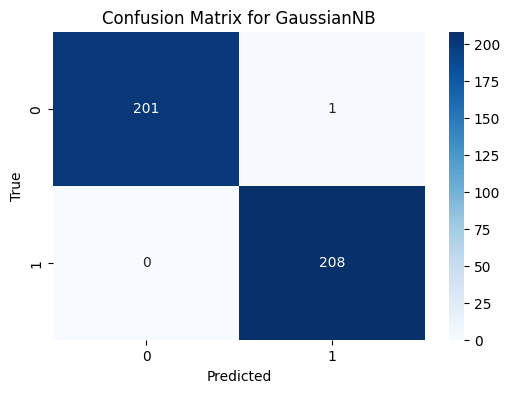

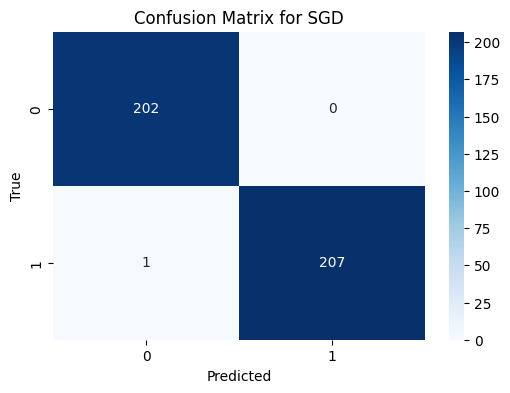

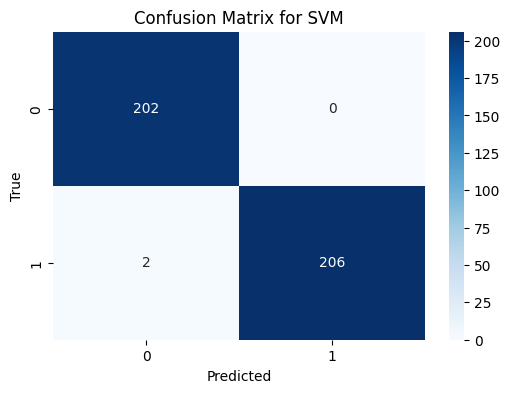

In [34]:
# Plot confusion matrices for top 3 models
top_models = performance_df.head(3)['Algorithm']
for name in top_models:
    model = models[name]
    _, _, _, _, y_pred = train_classifier(model, X_train, Y_train, X_test, Y_test)
    cm = confusion_matrix(Y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

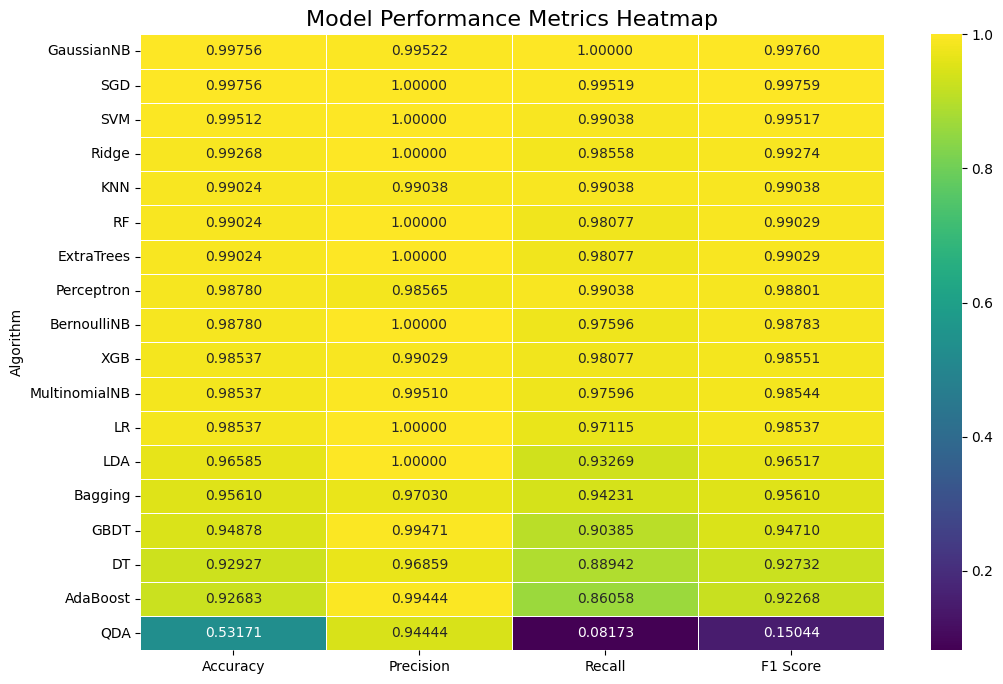

In [37]:
#  Heatmap
plt.figure(figsize=(12, 8))
metrics = performance_df.set_index('Algorithm')[['Accuracy', 'Precision', 'Recall', 'F1 Score']]
sns.heatmap(metrics, annot=True, cmap='viridis', fmt=".5f", linewidths=0.5)
plt.title('Model Performance Metrics Heatmap', fontsize=16)

# Save the chart as an image
plt.savefig('Results/Train_synthetic_english_sms_gemini/heatmap_model_performance_chart.png', dpi=600, bbox_inches='tight')

# Show the chart
plt.show()

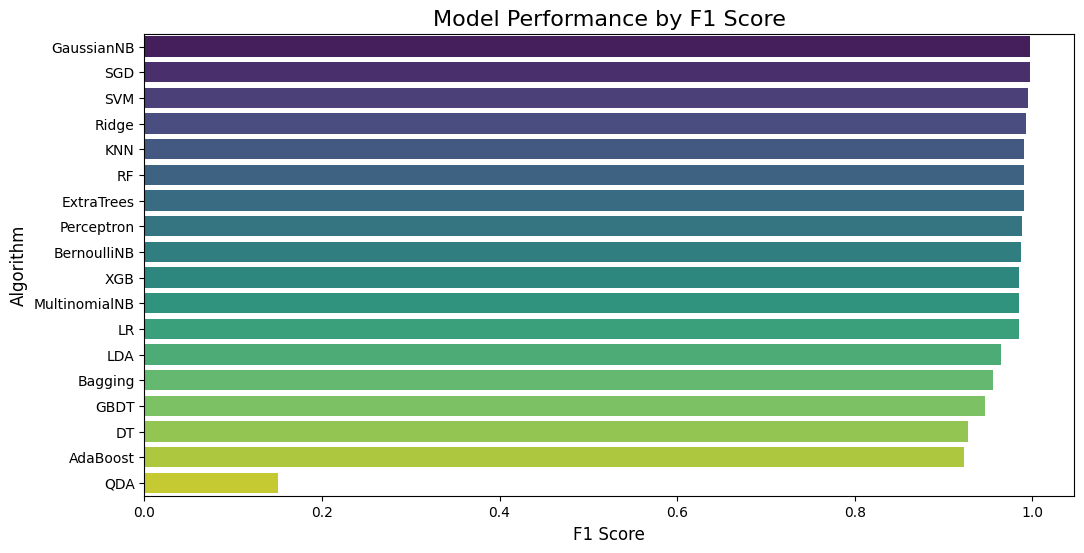

In [36]:
# Bar plot for F1 Score
plt.figure(figsize=(12, 6))
sns.barplot(x='F1 Score', y='Algorithm', data=performance_df, palette='viridis')
plt.title('Model Performance by F1 Score', fontsize=16)
plt.xlabel('F1 Score', fontsize=12)
plt.ylabel('Algorithm', fontsize=12)

# Save the chart as an image
plt.savefig('Results/Train_synthetic_english_sms_gemini/barplot_model_performance.png', dpi=600, bbox_inches='tight')

# Show the chart
plt.show()